# 75.06/95.58 Organización de Datos 
# Segundo Cuatrimestre de 2018

#  Trabajo Práctico 2

    

In [1]:
import locale
import pandas as pd
import matplotlib   #requerido para color map
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


#Tree Map
#import squarify

%matplotlib inline
plt.style.use('default')
#sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
# ---------------------------------------------------------------------------------
# Permite corregir el formato luego de aplicar un PIVOT
# ---------------------------------------------------------------------------------

# def reset_index(df):
#     '''Returns DataFrame with index as columns'''
#     index_df = df.index.to_frame(index=False)
#     df = df.reset_index(drop=True)
#     return pd.merge(index_df, df, left_index=True, right_index=True)


In [3]:

# Corregir el PATH al archivo si hace falta
eventsFilePath = 'data/events_up_to_01062018.csv'


eventos = pd.read_csv(eventsFilePath,
                    parse_dates=['timestamp'],
                    dtype={'event':'category', 'city':'category', 'region':'category', 'country':'category', 
                           'condition':'category', 'storage':'category', 'color' : 'category','device_type':'category',
                           'campaign_source':'category', 'search_engine':'category', 'channel':'category', 
                           'new_vs_returning':'category', 'screen_resolution':'category',
                           'skus':'str','search_term':'str',
                           'url':'category', 'sku':'category', 'model': 'category', 'staticpage':'category', 
                           'operating_system_version':'category','browser_version':'category'},
                     na_values=['Unknown', 'Desconocido'],
#                     low_memory=False,
                    infer_datetime_format=True)




In [4]:
# ---------------------------------------------------------------------------------
# Visualizo algunos datos
# ---------------------------------------------------------------------------------
events = eventos
display(events.size)
events.sample(3)


53858663

timestamp           event    person  url     sku                   model  condition storage     color skus search_term staticpage campaign_source search_engine channel new_vs_returning city region country device_type screen_resolution operating_system_version browser_version
258933 2018-03-12 18:45:40  viewed product  16fad36a  NaN  3659.0               iPhone 5c        Bom     8GB      Rosa  NaN         NaN        NaN             NaN           NaN     NaN              NaN  NaN    NaN     NaN         NaN               NaN                      NaN             NaN
894084 2018-05-26 21:01:32  viewed product  cf1a01a8  NaN  3361.0  Samsung Galaxy S6 Flat  Excelente    32GB     Preto  NaN         NaN        NaN             NaN           NaN     NaN              NaN  NaN    NaN     NaN         NaN               NaN                      NaN             NaN
767208 2018-05-19 20:34:54  viewed product  9b681612  NaN  1374.0           iPhone 6 Plus  Muito Bom    16GB  Prateado  NaN         NaN        NaN             NaN           NaN     NaN              NaN  NaN    NaN     NaN         NaN               NaN                      NaN             NaN

##  Training Data

In [5]:
labelsFilePath = 'data/labels_training_set.csv'
train_crudo = pd.read_csv(labelsFilePath,                    
                    dtype={'label':'int'},
                    low_memory=False)

train_crudo.head(1)

person  label
0  0566e9c1      0

### Visualizo cantidades y balanceo datos por Random Under-Sampling

In [6]:
original_conversion_frequency = train_crudo.groupby('label').count()
original_total_train = train_crudo.count()['person']
original_conversion = original_conversion_frequency.loc[1,:].values[0]
original_non_conversion = original_conversion_frequency.loc[0,:].values[0]
original_rate = original_conversion/original_total_train*100
#-------------------------------------------------
display('Total Observations',original_total_train)
display('Conversion', original_conversion)
display('Non conversion', original_non_conversion)
display('Conversions Rate (%)', original_rate)

'Total Observations'

19414

'Conversion'

980

'Non conversion'

18434

'Conversions Rate (%)'

5.047903574739879

##### Hago el balanceo
Método RUS: Tomo un sample de las no conversiones (PER = porcentaje del total mayoritario) y luego le agrego el total de las conversiones.

Ir probando con la constante PER: lo ideal es el ratio más alto con el menor dropeo de registros.

In [7]:
# Separo por label
conversions = train_crudo[train_crudo['label']==1]
non_conversions = train_crudo[train_crudo['label']==0]

# Ir probando con esta constante: lo ideal es el ratio más alto con el menor dropeo de registros.
PER = 7.5
cant_non_conv_undersampled = ((PER/100)*original_non_conversion).astype(int)
non_conv_undersampled = non_conversions.sample(cant_non_conv_undersampled)
# Agrego el total de las conversiones
frames = [non_conv_undersampled, conversions]
balanced_train = pd.concat(frames)
#-------------------------------------------------
balanced_conversion_frequency = balanced_train.groupby('label').count()
balanced_total_train = balanced_train.count()['person']
balanced_conversion = balanced_conversion_frequency.loc[1,:].values[0]
balanced_non_conversion = balanced_conversion_frequency.loc[0,:].values[0]
balanced_rate = balanced_conversion/balanced_total_train*100
#-------------------------------------------------
display('Total Observations',balanced_total_train)
display('Conversion', balanced_conversion)
display('Non conversion', balanced_non_conversion)
display('Conversions Rate (%)', balanced_rate)
display(f"Con el {PER} % tengo {cant_non_conv_undersampled} no conversiones y un ratio del {balanced_rate}.")
balanced_train.sample(5)

'Total Observations'

2362

'Conversion'

980

'Non conversion'

1382

'Conversions Rate (%)'

41.49026248941575

'Con el 7.5 % tengo 1382 no conversiones y un ratio del 41.49026248941575.'

person  label
13365  5293ba6d      0
16385  febfbe81      0
5321   fa293b26      0
9272   7db4883a      1
14561  2dc1198b      0

## Retomo eventos para la ingeniería de features

### Propiedades relacionadas al momento del evento

In [8]:
# ---------------------------------------------------------------------------------
# Completa el dataset con los las propiedades relacionadas a la fecha y hora
# ---------------------------------------------------------------------------------
# Numero de dia en el mes
events['dia_mes'] = events.timestamp.dt.day

# Numero de dia de la semana
events['dia_semana'] = events.timestamp.dt.dayofweek 

# Numero de dia del año (sirve para hacer diferencia de dias)
events['dia_anio'] = events.timestamp.dt.dayofyear

# Numero de mes
events['mes'] = events.timestamp.dt.month

# Hora
events['hora'] = events.timestamp.dt.hour

# Numero de semana 
events['semana'] = events.timestamp.dt.week


In [9]:
persona_dia_semana = events.pivot_table(index='person',columns='dia_semana', values='timestamp', aggfunc='count', fill_value=0).fillna(0).astype(int)
persona_dia_semana.columns = ['dia_semana_' +  str(col).replace(' ','_') for col in persona_dia_semana.columns]
persona_dia_semana = persona_dia_semana.reset_index()
# display(persona_dia_semana.head(5))

persona_dia_mes = events.pivot_table(index='person',columns='dia_mes', values='timestamp', aggfunc='count', fill_value=0).fillna(0).astype(int)
persona_dia_mes.columns = ['dia_mes_' +  str(col).replace(' ','_') for col in persona_dia_mes.columns]
persona_dia_mes = persona_dia_mes.reset_index()
# display(persona_dia_mes.head(5))

persona_hora = events.pivot_table(index='person',columns='hora', values='timestamp', aggfunc='count', fill_value=0).fillna(0).astype(int)
persona_hora.columns = ['hora_' +  str(col).replace(' ','_') for col in persona_hora.columns]
persona_hora = persona_hora.reset_index()
# display(persona_hora.head(5))

timestamp_attrs = pd.merge(persona_dia_semana, persona_dia_mes, how='outer', on=['person'])
timestamp_attrs = pd.merge(timestamp_attrs, persona_hora, how='outer', on=['person'])

timestamp_attrs.sample()

person  dia_semana_0  dia_semana_1  dia_semana_2  dia_semana_3  dia_semana_4  dia_semana_5  dia_semana_6  dia_mes_1  dia_mes_2  dia_mes_3  dia_mes_4  dia_mes_5  dia_mes_6  dia_mes_7  dia_mes_8  dia_mes_9  dia_mes_10  dia_mes_11  dia_mes_12  dia_mes_13  dia_mes_14  dia_mes_15  dia_mes_16  dia_mes_17  dia_mes_18  dia_mes_19  dia_mes_20  dia_mes_21  dia_mes_22  dia_mes_23  dia_mes_24  dia_mes_25  dia_mes_26  dia_mes_27  dia_mes_28  dia_mes_29  dia_mes_30  dia_mes_31  hora_0  hora_1  hora_2  hora_3  hora_4  hora_5  hora_6  hora_7  hora_8  hora_9  hora_10  hora_11  hora_12  hora_13  hora_14  hora_15  hora_16  hora_17  hora_18  hora_19  hora_20  hora_21  hora_22  hora_23
17439  7373dd43            38             0             0             0             0             0             0          0          0          0          0          0          0          0          0          0           0           0           0           0           0           0           0           0           0           0           0          38           0           0           0           0           0           0           0           0           0           0       0       0      38       0       0       0       0       0       0       0        0        0        0        0        0        0        0        0        0        0        0        0        0        0

### Separa marca y modelo

In [10]:
# ---------------------------------------------------------------------------------
#  Determina Marca y modelo y lo agrega como columnas
# ---------------------------------------------------------------------------------

def getModelo(marcaModelo):
    if (marcaModelo == marcaModelo):
        x=marcaModelo.split()
        return ' '.join(x[1:])
    return marcaModelo

# agrega columnas de marca y modelo
events['marca'] = events.model.str.split().str.get(0).astype('category')
events['modelo'] = events.model.apply(lambda x: getModelo(str(x))).astype('category') 
events['es_modelo_premium'] = events.model.str.split().str.get(-1).isin(['Prime','Plus','+', 'Z', 'Edge', 'Duos', 'Dual']).astype('int64')

# Elimina la columna model (solo hacerlo al finalde las pruebas por las dudas)
#events.drop(['model'], axis=1 , inplace=True)

events[['model','marca', 'modelo', 'es_modelo_premium' ]].head(1)


model    marca           modelo  es_modelo_premium
0  Samsung Galaxy J7 Prime  Samsung  Galaxy J7 Prime                  1

### MARCAS

Marcas visualizadas
Cantidad de marcas visualizada por la persona

In [11]:
persona_marca = events[(events.event=='viewed product')].pivot_table(index='person',columns='marca', values='timestamp', aggfunc='count', fill_value=0).fillna(0).astype(int)
persona_marca.columns = ['marca_' +  col.replace(' ','_') for col in persona_marca.columns]
persona_marca = persona_marca.reset_index()

persona_marca.columns

Index(['person', 'marca_Asus', 'marca_LG', 'marca_Lenovo', 'marca_Motorola', 'marca_Outros', 'marca_Quantum', 'marca_Samsung', 'marca_Sony', 'marca_Xiaomi', 'marca_iPad', 'marca_iPhone'], dtype='object')

In [12]:
#Cantidad de visualizaciones de producto por marca para cada persona
persona_m = events[(events.event=='viewed product')].groupby(['person','marca']).size().to_frame('marca_cant').reset_index().drop('marca_cant', axis=1)
persona_m = persona_m.groupby(['person']).size().to_frame('cant_marcas_vistas').reset_index()

In [13]:
#Junta los dos df
persona_marca = pd.merge(persona_marca, persona_m, how='outer', on=['person'])
persona_marca.head()

person  marca_Asus  marca_LG  marca_Lenovo  marca_Motorola  marca_Outros  marca_Quantum  marca_Samsung  marca_Sony  marca_Xiaomi  marca_iPad  marca_iPhone  cant_marcas_vistas
0  00091926           0         2             1              55             0              0             61           1             0           1           251                   7
1  00091a7a           0         0             0               0             0              0              0           0             0           0             3                   1
2  000ba417           0         4             0              35             0              0            105           1             0           0             8                   5
3  000c79fe           0         0             0               0             0              0              0           0             0           0             3                   1
4  000e4d9e           0         1             0               2             0              0            300          15             0           0            21                   5


### MODELOS

In [14]:
# persona_modelo = (events.set_index('person')['modelo']
#         .str.split(expand=True)
#         .stack()
#         .reset_index(level=1, drop=True)
#         .reset_index(name='modelo')
#         .drop_duplicates()
#        )
# persona_modelo = pd.concat([persona_modelo,pd.get_dummies(persona_modelo['modelo'], prefix='mod')],axis=1)

In [15]:
# persona_modelo = persona_modelo.drop('modelo', axis=1)

In [16]:
# persona_modelo = persona_modelo.groupby('person').sum()
# persona_modelo.sample()

### Es modelo premium?

True para 'plus', 'edition', 'edge', etc


In [17]:
es_premium = events.groupby('person')[['es_modelo_premium']].sum().reset_index()

persona_marca = pd.merge(persona_marca, es_premium, how='outer', on=['person'])
# persona_marca.head()

#### SKUS como nocion de ingreso a stock
Creo una col con SKU categ ordenada, intentando un approach por tiempo de ingreso a stock del modelo (menor ID, más tiempo en la web, más viejo el teléfono).

In [18]:
# categ ordered falla por bug. lo hago con floats (sku_num).

# genero sku uniques ordenados para el ordenamiento de categoría
events['sku_num'] = events['sku'].astype('float32')# Traigo de eventos sku y persona
persona_skunum_grouped = events.groupby('person')[['sku_num']]

# Tiro un describe para ver qué hay:
# persona_skunum_grouped.describe()

In [19]:
sku_diffs = persona_skunum_grouped.nunique().rename(index=str,columns={'sku_num':'sku_diffs'}).reset_index()
sku_diffs.head(3)

person  sku_diffs
0  0008ed71          3
1  00091926        164
2  00091a7a          3

In [20]:
sku_mean = persona_skunum_grouped.mean().rename(index=str,columns={'sku_num':'sku_mean'}).reset_index()
sku_mean.head(3)

person     sku_mean
0  0008ed71  6374.666504
1  00091926  7190.058594
2  00091a7a  5487.666504

In [21]:
sku_max = persona_skunum_grouped.max().rename(index=str,columns={'sku_num':'sku_max'}).reset_index()
sku_max.head(3)

person  sku_max
0  0008ed71   8247.0
1  00091926  15819.0
2  00091a7a   8261.0

In [22]:
sku_min = persona_skunum_grouped.min().rename(index=str,columns={'sku_num':'sku_min'}).reset_index()
sku_min.head(3)

person  sku_min
0  0008ed71   3372.0
1  00091926   1365.0
2  00091a7a   1357.0

In [23]:
sku_std = persona_skunum_grouped.std().rename(index=str,columns={'sku_num':'sku_std'}).reset_index()
sku_std.head(3)

person      sku_std
0  0008ed71  2626.717773
1  00091926  2983.039795
2  00091a7a  3646.651855

In [24]:
sku_median = persona_skunum_grouped.median().rename(index=str,columns={'sku_num':'sku_median'}).reset_index()
sku_median.head(3)

person  sku_median
0  0008ed71      7505.0
1  00091926      7013.5
2  00091a7a      6845.0

In [25]:
sku_var = persona_skunum_grouped.var().rename(index=str,columns={'sku_num':'sku_var'}).reset_index()
sku_var.head(3)

person     sku_var
0  0008ed71   6899646.5
1  00091926   8898526.0
2  00091a7a  13298069.0

In [26]:
sku_numbers = pd.merge(sku_var, sku_median, how='outer', on=['person'])
sku_numbers = pd.merge(sku_numbers, sku_std, how='outer', on=['person'])
sku_numbers = pd.merge(sku_numbers, sku_min, how='outer', on=['person'])
sku_numbers = pd.merge(sku_numbers, sku_max, how='outer', on=['person'])
sku_numbers = pd.merge(sku_numbers, sku_mean, how='outer', on=['person'])
sku_numbers = pd.merge(sku_numbers, sku_diffs, how='outer', on=['person'])
                       
sku_numbers.head()

person     sku_var  sku_median      sku_std  sku_min  sku_max     sku_mean  sku_diffs
0  0008ed71   6899646.5      7505.0  2626.717773   3372.0   8247.0  6374.666504          3
1  00091926   8898526.0      7013.5  2983.039795   1365.0  15819.0  7190.058594        164
2  00091a7a  13298069.0      6845.0  3646.651855   1357.0   8261.0  5487.666504          3
3  000ba417  13395084.0      5459.0  3659.929443    220.0  15759.0  6559.893555         81
4  000c79fe         0.0      9944.0     0.000000   9944.0   9944.0  9944.000000          1

### Otros

In [27]:
lugares_diff = eventos.groupby(['person']).nunique()[['city']].rename(index=str,columns={'city':'lugares_diferentes'}).reset_index()
lugares_diff.head(5)

person  lugares_diferentes
0  0008ed71                   0
1  00091926                   1
2  00091a7a                   1
3  000ba417                   1
4  000c79fe                   1

In [28]:
persona_condicion = eventos.groupby(['person']).nunique()[['condition']].rename(index=str,columns={'condition':'condiciones_diferentes'}).reset_index()
persona_condicion.head(1)

person  condiciones_diferentes
0  0008ed71                       2

In [29]:
colores_diff = eventos.groupby(['person']).nunique()[['color']].rename(index=str,columns={'color':'colores_diferentes'}).reset_index()
colores_diff.head(1)

person  colores_diferentes
0  0008ed71                   3

In [30]:
events['es_color_popular'] = events.color.isin(['Preto','Negro','Branco', 'Blanco', 'Oro', 'Ouro', 'Gold','Dourado','Black', 'White']).astype('int64')

es_color_popular = events.groupby('person')[['es_color_popular']].sum().reset_index()

persona_color = pd.merge(es_color_popular, colores_diff, how='outer', on=['person'])

# events[['color','es_color_popular']].sample(20)

### Dias activo

In [31]:
# Dias activo
#---------------------------------------
dias_activo = events.groupby('person').dia_anio.nunique().to_frame(name='dias_activo').reset_index() #.set_index('person')
dias_activo.head(3)

person  dias_activo
0  0008ed71            1
1  00091926           22
2  00091a7a            1

### Pais

In [32]:
# Cantidad minima de personas para considerar el pais sino engloba por 'Otros'
cantidad_min_por_pais = 10

paises_personas_tmp = events.groupby(['person','country']).size().to_frame(name='country_cant').reset_index().drop('country_cant', axis=1)
#display(paises_personas_tmp.head(3))

# Cambia Country por pais agrupando en 'Otros' los muy chiquitos
paises = paises_personas_tmp.groupby(['country']).size().to_frame(name='person_cant').reset_index().sort_values('person_cant', ascending=False).reset_index()
paises = paises.drop(['index'], axis=1)
paises['pais'] = paises.apply(lambda r: r['country'] if r['person_cant'] >= cantidad_min_por_pais else 'Otros', axis=1)
paises = paises.drop(['person_cant'], axis=1)
# Corrige nombres de paises especificos
paises.loc[paises.pais == 'Unknown', 'pais'] = 'Desconocido'
paises.loc[paises.pais == 'United Kingdom', 'pais'] = 'UK'
paises.loc[paises.pais == 'United States', 'pais'] = 'USA'

# Genera la tabla de personas paises donde cada persona aparece una sola vez
paises_personas_tmp = paises_personas_tmp.drop_duplicates()
persona_pais = pd.merge(paises_personas_tmp, paises, how='inner', on=['country']).drop('country', axis=1).drop_duplicates()
persona_pais = pd.concat([persona_pais,pd.get_dummies(persona_pais['pais'], prefix='pais')],axis=1).drop('pais', axis=1).groupby('person').sum().reset_index()
# persona_pais.head()

### Dispositivo (Device_type)

In [33]:
# device_type
#---------------------------------------

persona_device = events.groupby(['person','device_type']).size().to_frame('device_type_cant').reset_index().drop('device_type_cant', axis=1)
persona_device = pd.concat([persona_device,pd.get_dummies(persona_device['device_type'], prefix='dispo')],axis=1).drop('device_type', axis=1).groupby('person').sum().reset_index()
# persona_device.head(5)




### Canal

Cantidad de acceso por cada canal

In [34]:

# Cantidad de acceso por cada canal
#---------------------------------------

persona_canal = events.groupby(['person','channel']).size().to_frame('channel_cant').reset_index()\
    .pivot_table(index='person',columns='channel', values='channel_cant', aggfunc='sum').fillna(0).astype(int)   
persona_canal.columns = ['canal_' +  col for col in persona_canal.columns]
persona_canal = persona_canal.reset_index()
# persona_canal.head(5)
 

###  Campaña de origen 

In [35]:
persona_campania = events.groupby(['person','campaign_source']).size().to_frame('campania_cant').reset_index()\
    .pivot_table(index='person',columns='campaign_source', values='campania_cant', aggfunc='sum').fillna(0).astype(int)   
persona_campania.columns = ['campania_' +  col.replace(' ','_') for col in persona_campania.columns]

persona_campania = persona_campania.reset_index()
# persona_campania.head()


### Static Page

In [36]:
"""
CustomerService                      5239
FaqEcommerce                         1317
AboutUs                              1217
Quiosks                               868
trust-trocafone                       632
TermsAndConditionsReturnEcommerce     528
galaxy-s8                             380
Conditions                            285
how-to-sell                           234
how-to-buy                            232
TermsAndConditionsEcommerce           119
club-trocafone                        107
PrivacyEcommerce                       28
black_friday                           15
"""
persona_staticpage = events.groupby(['person','staticpage']).size().to_frame('staticpage_cant').reset_index()\
    .pivot_table(index='person',columns='staticpage', values='staticpage_cant', aggfunc='sum').fillna(0).astype(int)
    
persona_staticpage.columns = ['staticpage_' +  col.replace(' ','_') for col in persona_staticpage.columns]
persona_staticpage = persona_staticpage.reset_index()

persona_staticpage.head(1)

person  staticpage_AboutUs  staticpage_Conditions  staticpage_CustomerService  staticpage_FaqEcommerce  staticpage_PrivacyEcommerce  staticpage_Quiosks  staticpage_TermsAndConditionsEcommerce  staticpage_TermsAndConditionsReturnEcommerce  staticpage_black_friday  staticpage_club-trocafone  staticpage_galaxy-s8  staticpage_how-to-buy  staticpage_how-to-sell  staticpage_trust-trocafone
0  0027574e                   0                      1                           0                        0                            0                   0                                       0                                             0                        0                          0                     0                      0                       0                           0

### Indicadores de sesiones

In [37]:
# Plazo maximo en minutos para considerar dos eventos consecutivos que pertenecen a la misma sesion
plazolapsoMismaSesion = 30

#Ordena los registros
sesiones = events[['person','timestamp']].sort_values(by=['person','timestamp'],ascending=[True,True])

#Calcula el lapso transcurrido con el evento anterior
sesiones['lapso'] = sesiones['timestamp'].diff().dt.total_seconds()/60.0

#Si cambia de persona no calcula lapso
sesiones.loc[sesiones.person != sesiones.person.shift(), 'lapso'] = None

# Si supera el lapso maximo es una nueva sesion no calcula lapso
sesiones.loc[sesiones.lapso > plazolapsoMismaSesion, 'lapso'] = None

# Auxiliares Booleanos para calcular la duracion de las sesiones
# Estoy en la misma sesion si no supero al plazo maximo entre eventos (los NaN tampoco son de la misma sesion)
sesiones['misma_sesion'] = sesiones['lapso'] < plazolapsoMismaSesion

# El negado del anterior indica donde empieza la sesion
sesiones['inicio_sesion'] = ~sesiones.misma_sesion 

# Un registro antes del fin de sesion indica donde termina la sesion anterior por lo que 
# dezplaza el inicio de sesion un lugar para atras
sesiones['fin_sesion'] = sesiones.inicio_sesion
sesiones.fin_sesion = sesiones.fin_sesion.shift(-1).fillna(True)

# Auxiliar para contabilizar las sesiones. 
sesiones['aux_sesion'] = 0

# Pone 1 a todos los auxiliares con inicios de sesion
sesiones.loc[sesiones.inicio_sesion, 'aux_sesion'] = 1

# Numera todas las sesiones usando corte de control y la funcion de suma acumulada
sesiones['nume_sesion'] = sesiones.groupby(['person'])['aux_sesion'].apply(lambda x: x.cumsum())

# Obtiene la tabla resumida de sesiones por cada person 
# Acumula los lapsos entre eventos de cada sesion
sesiones_resumen = sesiones.groupby(['person','nume_sesion']).agg({'lapso': np.sum }).reset_index()

# Calcula las duraciones minima, maxima y total de la duracion de las sesiones y la cantidad de sesiones
sesiones_resumen = sesiones_resumen.groupby(['person']).agg({'lapso': [np.min,np.max,np.sum], 'nume_sesion' : np.size }).reset_index()

# Cambia nombre a las columnas
sesiones_resumen.columns = ['person', 'sesion_minutos_min', 'sesion_minutos_max','sesion_minutos_sum','sesion_cant' ] 

#Agrega duracion Promedio sesion
sesiones_resumen['sesion_minutos_avg'] = sesiones_resumen.sesion_minutos_sum / sesiones_resumen.sesion_cant

sesiones_resumen.head(3)


person  sesion_minutos_min  sesion_minutos_max  sesion_minutos_sum  sesion_cant  sesion_minutos_avg
0  0008ed71            0.016667            6.716667            6.733333            3            2.244444
1  00091926            0.000000           35.483333          248.166667           34            7.299020
2  00091a7a            5.783333            5.783333            5.783333            1            5.783333

### Eventos Importantes

In [38]:
#Fecha de la ultima conversion conocida
import datetime
dia20180601 = datetime.date(2018,6,1).timetuple().tm_yday

# desde ultima conversion
persona_conversiones_last = events[events.event=='conversion'].groupby(['person'])['dia_anio'].max().to_frame(name='dia_ult_conver').reset_index()
persona_conversiones_last['dias_sin_convertir'] = dia20180601 - persona_conversiones_last.dia_ult_conver

# desde primera conversion
persona_conversiones_1st = events[events.event=='conversion'].groupby(['person'])['dia_anio'].min().to_frame(name='dia_1raConv2018').reset_index()
persona_conversiones_1st['dias_desde_1eraConv2018'] = dia20180601 - persona_conversiones_1st.dia_1raConv2018

persona_conversiones = pd.merge(persona_conversiones_1st, persona_conversiones_last, how='outer', on=['person'])

# convirtieron solo un día
persona_conversiones['convirtio_un_solo_dia'] = (persona_conversiones['dia_ult_conver'] == persona_conversiones['dia_1raConv2018']).astype('int64')

persona_conversiones_median = events[events.event=='conversion'].groupby(['person'])['dia_anio'].median().to_frame(name='dia_mid_conver').reset_index()
persona_conversiones_median['dias_desde_medianConv2018'] = dia20180601 - persona_conversiones_median.dia_mid_conver

fechas_conversiones = pd.merge(persona_conversiones, persona_conversiones_median, how='outer', on=['person'])

# persona_conversiones.withColumn("d", col("b") === col("c"))
fechas_conversiones.head()


person  dia_1raConv2018  dias_desde_1eraConv2018  dia_ult_conver  dias_sin_convertir  convirtio_un_solo_dia  dia_mid_conver  dias_desde_medianConv2018
0  000ba417              146                        6             146                   6                      1           146.0                        6.0
1  001001be              136                       16             136                  16                      1           136.0                       16.0
2  001804a2              145                        7             145                   7                      1           145.0                        7.0
3  0019e639               40                      112             142                  10                      0            91.0                       61.0
4  001b0bf9              142                       10             142                  10                      1           142.0                       10.0

## Armado del Dataset

In [40]:
#Inicializa el dataframe de personas
personas = events.person.drop_duplicates().to_frame()
# personas.fillna(value=9999,inplace=True)

personas = pd.merge(personas, timestamp_attrs,   on='person', how='outer')
personas = pd.merge(personas, fechas_conversiones,   on='person', how='outer')
personas = pd.merge(personas, dias_activo,         on='person', how='outer')
personas = pd.merge(personas, sku_numbers,         on='person', how='outer')
personas = pd.merge(personas, persona_marca,       on='person', how='outer')  
personas = pd.merge(personas, sesiones_resumen,    on='person', how='outer')
personas = pd.merge(personas, persona_campania,    on='person', how='outer')
personas = pd.merge(personas, persona_canal,       on='person', how='outer')
personas = pd.merge(personas, persona_condicion,   on='person', how='outer')
personas = pd.merge(personas, persona_pais,        on='person', how='outer')  
personas = pd.merge(personas, persona_color,      on='person', how='outer')  
personas = pd.merge(personas, persona_device,      on='person', how='outer')
personas = pd.merge(personas, lugares_diff,     on='person', how='outer')
personas = pd.merge(personas, persona_staticpage,  on='person', how='outer')


personas.columns.nunique(),personas.columns

(124,
 Index(['person', 'dia_semana_0', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4', 'dia_semana_5', 'dia_semana_6', 'dia_mes_1', 'dia_mes_2',
        ...
        'staticpage_PrivacyEcommerce', 'staticpage_Quiosks', 'staticpage_TermsAndConditionsEcommerce', 'staticpage_TermsAndConditionsReturnEcommerce', 'staticpage_black_friday', 'staticpage_club-trocafone', 'staticpage_galaxy-s8', 'staticpage_how-to-buy', 'staticpage_how-to-sell', 'staticpage_trust-trocafone'], dtype='object', length=124))

## Armo datasets para la ejecución

In [41]:
from sklearn.model_selection import train_test_split

personas_train = pd.merge(personas, balanced_train,    on='person', how='inner')
personas_train.fillna(value=0,inplace=True)

# Hace un split de los dataset de entrenamiento y evaluacion
X, y = personas_train.iloc[:,1:-1],personas_train.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2  )   #, random_state=123



# Gradient boost

0.6638477801268499

c:\program files (x86)\python36-32\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(array([0.        , 0.29809725, 1.        ]),
 array([nan, nan, nan]),
 array([2, 1, 0]))

[Text(0,0.5,'no conv'), Text(0,1.5,'conversion')]

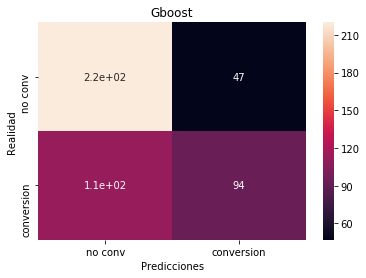

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

gbc = GradientBoostingClassifier()#n_estimators=)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

display(gbc.score(X_test, y_test))

display(metrics.roc_curve(y_test, y_pred, pos_label=2))

from sklearn.metrics import confusion_matrix
cm_gbc = confusion_matrix(y_test, y_pred)

list1 = ["Real 0", "Real 1"]
list2 = ["Pred 0", "Pred 1"]
pd.DataFrame(cm_gbc, list1,list2)

ax= plt.subplot()
sns.heatmap(cm_gbc, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicciones')
ax.set_ylabel('Realidad') 
ax.set_title('Gboost')
ax.xaxis.set_ticklabels(['no conv', 'conversion'])
ax.yaxis.set_ticklabels(['no conv', 'conversion'])

# Logistic regression

0.6004228329809725

[Text(0,0.5,'no conv'), Text(0,1.5,'conversion')]

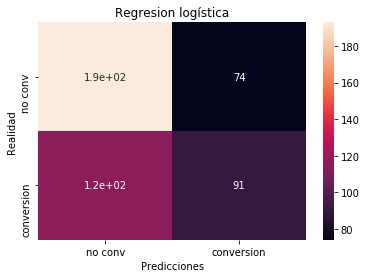

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = LogisticRegression(
C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

list1 = ["Real 0", "Real 1"]
list2 = ["Pred 0", "Pred 1"]
pd.DataFrame(cm_lr, list1,list2)

ax= plt.subplot()
sns.heatmap(cm_lr, annot=True, ax = ax) # annot=True to annotate cells
display(logreg.score(X_test, y_test))
# labels, title and ticks
ax.set_xlabel('Predicciones')
ax.set_ylabel('Realidad') 
ax.set_title('Regresion logística')
ax.xaxis.set_ticklabels(['no conv', 'conversion'])
ax.yaxis.set_ticklabels(['no conv', 'conversion'])